In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import copy
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import scipy.stats as stats

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

import hdp_scripts as hdp
import multivariate_normal
import classification_evaluation as hdp_eval
import data_generation as gen
import imp # for reloading a local script
import time
imp.reload(multivariate_normal)
from multivariate_normal import MultivariateNormal
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'data_generation' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/data_generation.py'>

## Generate some data that might look like ESSIL

In [346]:
d_w, p_w, j_w, wl_w, wf_w = 0, 0, 0, 0, 1
water = []
water.append(np.array([d_w, p_w, j_w, wl_w, wf_w]))

def generate_new_transition_matrix(dim=5, perturbation_strength=1):
    transition_matrix = np.eye(dim)

    perturbation = np.random.dirichlet([0.1, 0.1, 0.1, 0.1, 0.6], size=5)/perturbation_strength
    transition_matrix += perturbation
    
    # normalize along columns
    transition_matrix /= np.sum(transition_matrix, axis=1)
    
    return transition_matrix

p_s = 100
T_matrix = generate_new_transition_matrix(perturbation_strength=p_s)
chain = 0
chains = [chain]

for i in range(600):
    
    chains.append(chain)
    if np.random.binomial(n=1, p=0.005) == 1:
        T_matrix = generate_new_transition_matrix(perturbation_strength=p_s)
        print(i)
        chain += 1
        
    # add some noise
    perturbation_prime = np.random.dirichlet(np.ones(5), size=5)
    T_matrix_prime = T_matrix + perturbation_prime/50
    
    T_matrix_prime /= np.sum(T_matrix_prime, axis=1)
    water.append(water[-1].dot(T_matrix_prime))

228
493
547


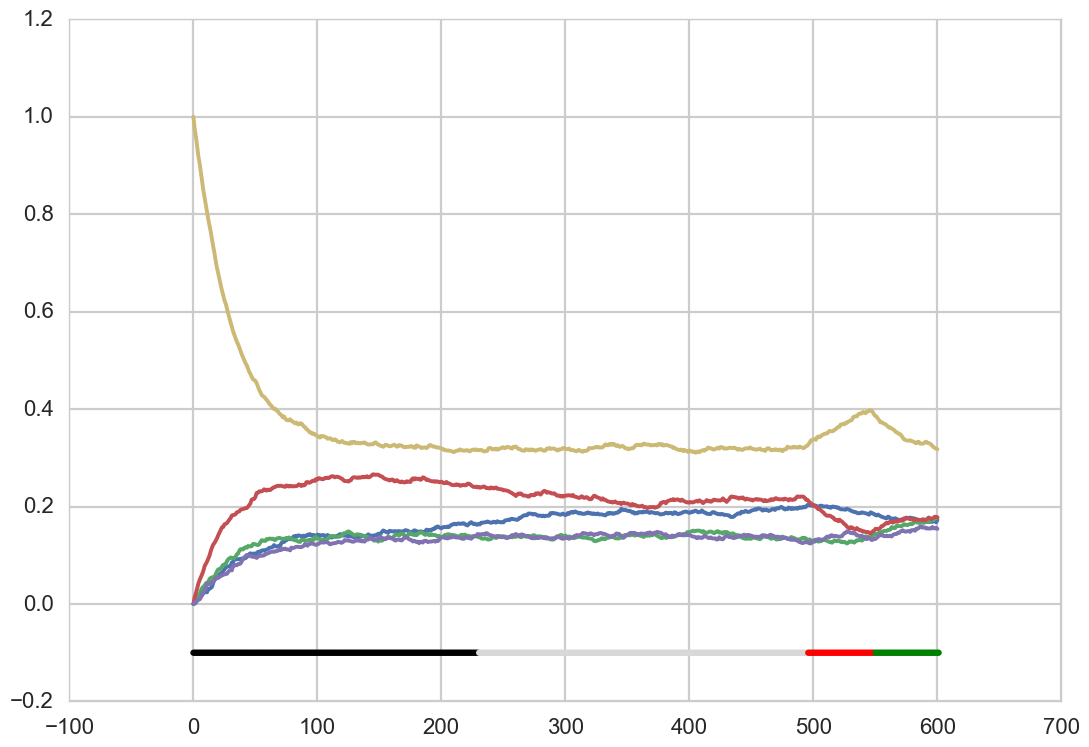

In [347]:
c=['black','#d8d8d8', 'r', 'g', 'b', 'y', '#42e5f4', '#42e5f4', '#f47a41', 'blue',
  '#597757', '#576977', '#635777', '#635777', '#0FF000']

water = np.array(water)

for i in range(5):
    plt.plot(water[:, i])
    
plt.scatter(np.linspace(0,len(chains),num=len(chains)), -0.1*np.ones_like(chains), c=[c[i] for i in chains], lw=0)

In [348]:
Y = water
# Y = water[:, :4]
Y

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       [8.15929752e-04, 6.71533241e-03, 1.41670646e-02, 2.62926774e-03,
        9.75672406e-01],
       [2.73695082e-03, 1.05186017e-02, 2.20087408e-02, 5.23541093e-03,
        9.59500296e-01],
       ...,
       [1.69589602e-01, 1.75764782e-01, 1.79229786e-01, 1.55147443e-01,
        3.20268387e-01],
       [1.67577773e-01, 1.78590092e-01, 1.78607797e-01, 1.56713198e-01,
        3.18511140e-01],
       [1.72717355e-01, 1.76987825e-01, 1.78093209e-01, 1.54227088e-01,
        3.17974523e-01]])

In [350]:
params = {}

L = 10
D = 5

params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array(np.eye(D)), 'sigma': 1*np.eye(D)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 0.1*len(Y)
params['gamma'] = 1
params['priors'] = {
    'M': np.zeros(shape=(D,D)),
    'K': 1*np.eye(D)
}

params, res, assignments_ar1, _ = hdp.sticky_Multi_HDP_AR(Y, params, priors=[np.cov(Y.T), D+2],
                                             num_iter=100,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

Iteration: 0, # inf chain: 10, time: 2.04, hamming_dist: 528.000


ValueError: the input matrix must be positive semidefinite

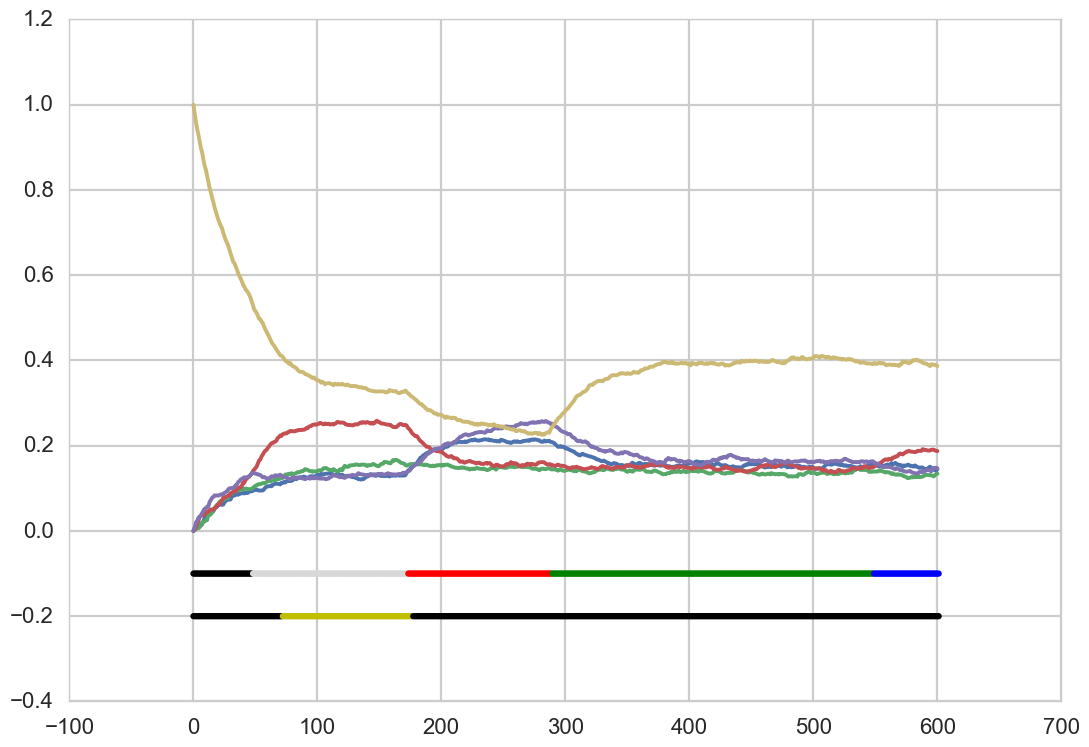

In [84]:
for i in range(5):
    plt.plot(water[:, i])
    
plt.scatter(np.linspace(0,len(chains),num=len(chains)), -0.1*np.ones_like(chains), c=[c[i] for i in chains], lw=0)
plt.scatter(np.linspace(0,len(chains),num=len(chains)), -0.2*np.ones_like(chains), c=[c[i] for i in res], lw=0)

In [85]:
useful = np.unique(res)
useful

array([0, 5], dtype=int16)

In [86]:
params['theta'][useful[0]]['A']

array([[ 3.1376272e-01,  1.8733512e-01,  1.7643346e-01,  3.1562936e-01,
        -5.7092350e-04],
       [ 1.8778747e-01,  1.8779670e-01,  1.9436122e-01,  1.8296237e-01,
         3.5336129e-02],
       [ 1.6829206e-01,  2.0041344e-01,  3.6718866e-01,  1.2487180e-01,
         4.8749439e-02],
       [ 3.1490558e-01,  1.8648122e-01,  1.3146578e-01,  4.0883756e-01,
         2.2342483e-02],
       [ 6.8437513e-03,  4.1709725e-02,  4.7987178e-02,  2.1455990e-02,
         9.4648433e-01]], dtype=float32)

In [97]:
water_sim = [np.array([0,0,0,0,1])]

for i in range(600):
    
    T_matrix_sim = params['theta'][res[i]]['A']
    
    if i > 1:
        if res[i] != res[i-1]:
            water_sim[-1] = water[-1]
    
    next_water = 0.75*water_sim[-1] + 0.25*np.abs(water_sim[-1].dot(T_matrix_sim))
    next_water /= np.sum(next_water)
    
    water_sim.append(next_water)

water_sim = np.array(water_sim)

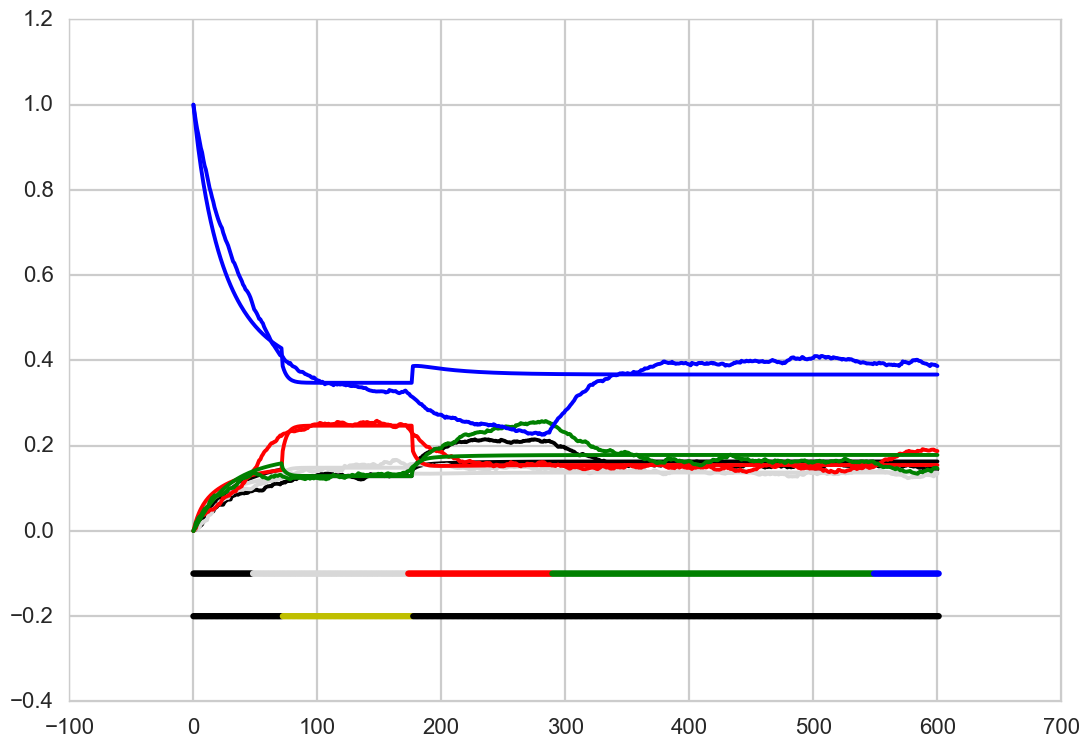

In [98]:
for i in range(5):
    plt.plot(water[:, i], c=c[i])
    plt.plot(water_sim[:, i], c=c[i])
    
plt.scatter(np.linspace(0,len(chains),num=len(chains)), -0.1*np.ones_like(chains), c=[c[i] for i in chains], lw=0)
plt.scatter(np.linspace(0,len(chains),num=len(chains)), -0.2*np.ones_like(chains), c=[c[i] for i in res], lw=0)

In [381]:
df = pd.read_csv('test5-2017-11-16T11-41.csv')
df.head(5)
import datetime

def clean_column_names(df):
    df.columns = df.columns.str.strip()
    df = df.iloc[1:].reset_index()
    return df

def forward_fill_time(df):
    
    # correct for the seconds that are missing / remove duplicates.
    # forward fill the values in all instances where missing
    
    # convert to datetime object
    time_values = df['Timestamp'].apply(lambda x: datetime.datetime(*[int(v) for v in x.split('-')]))
    # correct the time object in the dataframe
    df['Timestamp'] = time_values
    # create a new dataframe
    df_new = pd.DataFrame({'Timestamp': pd.date_range(time_values.min(), time_values.max(), freq='S')})
    
    return df_new.merge(df, how='left').ffill()

def get_bin_water_values(df, biomes=['Desert', 'Plains', 'Jungle', 'Wetlands']):
    
    # get the bin water value and convert to the same units 
    # as the global water values
    for biome in biomes:
        df[biome+'_BinsWater'] = (df[biome+'_WaterBins'].apply(lambda x: np.sum([float(v) for v in x.split('-')])) + 
                                  df[biome+'_FloodBins'].apply(lambda x: np.sum([float(v) for v in x.split('-')])))/60
    return df

def get_clouds_water(df, biomes=['Desert', 'Plains', 'Jungle', 'Wetlands']):
    
    for biome in biomes:
        df[biome+'_CloudsWater'] = df[biome+'_Water'] - df[biome+'_BinsWater']
        df[biome+'_Water'] = df[biome+'_BinsWater']
        
    df['_CloudWater'] = df[[(b+'_CloudsWater') for b in biomes]].sum(axis=1)
    return df

def filter_to_the_useful_columns(df, 
                                 biomes=["", 'Desert', 'Plains', 'Waterfall', 'Floor', 'Jungle', 'Reservoir', 'Wetlands', 'MountainValley'],
                                 useful=['Water', 'CloudWater']):
    
    known_columns = df.columns
    
    # get the most useful columns out
    columns = []
    for biome in biomes:
        for column in useful:
            suggestion = biome + '_' + column
            if suggestion in known_columns:
                columns.append(suggestion)
    
    return df[columns]

df = clean_column_names(df)
df = forward_fill_time(df)
df = get_bin_water_values(df)
df = get_clouds_water(df)
df = filter_to_the_useful_columns(df)
df.head()

,_CloudWater,Desert_Water,Plains_Water,Waterfall_Water,Floor_Water,Jungle_Water,Reservoir_Water,Wetlands_Water,MountainValley_Water
0,0.0,0.0,0.0,1.87670,0.00971,0.0,0.45,0.0,0.099488
1,0.0,0.0,0.0,1.87536,0.00971,0.0,0.45,0.0,0.093666
2,0.0,0.0,0.0,1.87566,0.00971,0.0,0.45,0.0,0.087303
3,0.0,0.0,0.0,1.87433,0.00971,0.0,0.45,0.0,0.082194
4,0.0,0.0,0.0,1.87531,0.00000,0.0,0.45,0.0,0.077384


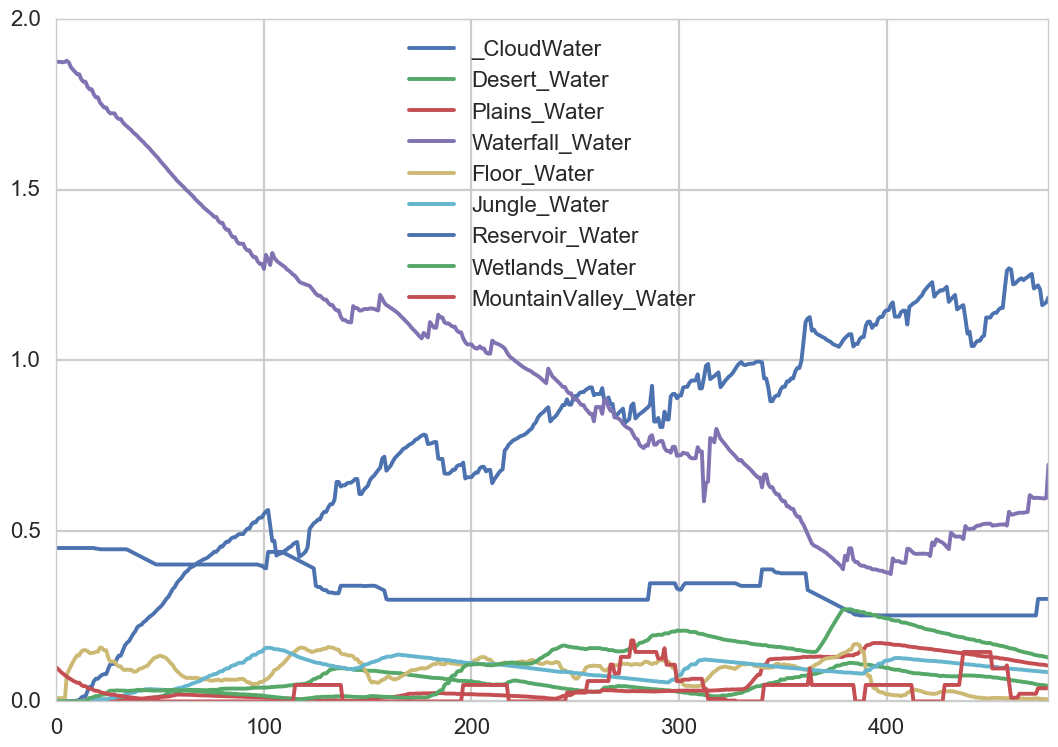

In [382]:
df.plot()

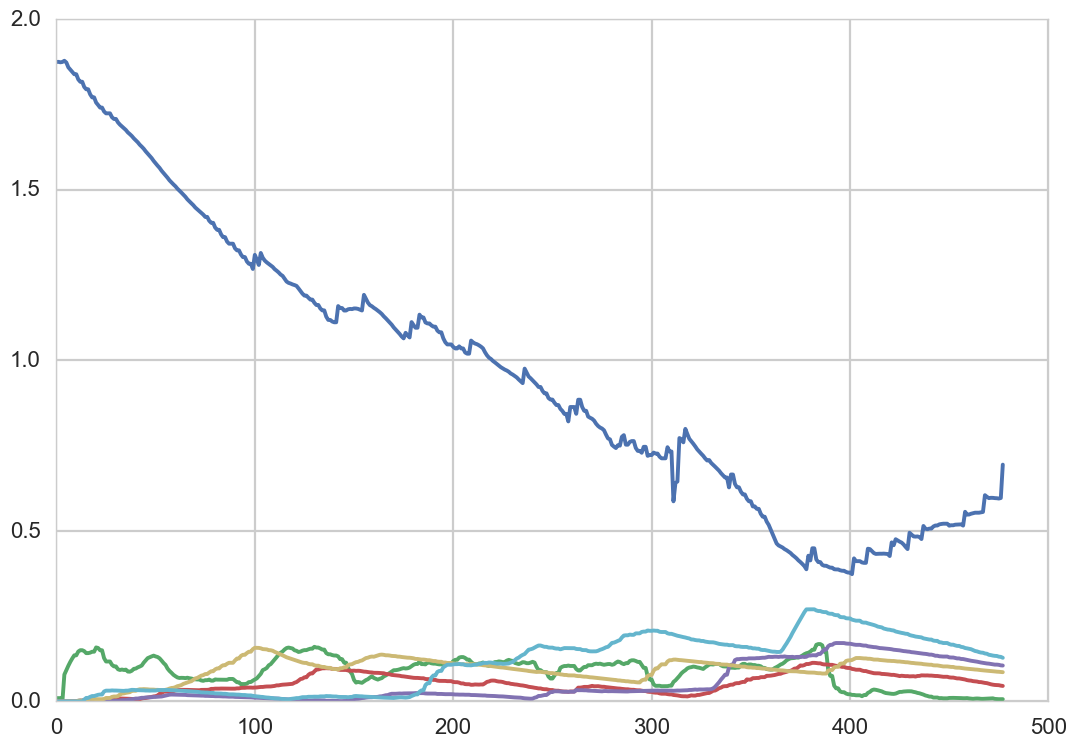

In [383]:
Y = df[['Waterfall_Water', 'Floor_Water', 'Desert_Water', 'Plains_Water', 'Jungle_Water', 'Wetlands_Water']].values[1:]
# Y[:,0] = .1
# Y -= np.mean(Y, axis=1).reshape(-1,1)
# Y = signal.detrend(Y, axis=-1, type='constant')
# Y -= np.mean(Y, axis=0)
plt.plot(Y)

In [384]:
np.cov(Y.T)

array([[ 1.71341199e-01,  6.22676680e-03, -7.32518273e-03,
        -1.89023471e-02, -7.29760411e-03, -3.00090950e-02],
       [ 6.22676680e-03,  1.78844525e-03, -1.44484227e-04,
        -1.18873275e-03, -3.47528384e-04, -9.99079404e-04],
       [-7.32518273e-03, -1.44484227e-04,  8.26730781e-04,
         9.40639221e-04,  5.90194560e-04,  7.63763214e-04],
       [-1.89023471e-02, -1.18873275e-03,  9.40639221e-04,
         3.16521755e-03,  4.79877088e-04,  3.45118529e-03],
       [-7.29760411e-03, -3.47528384e-04,  5.90194560e-04,
         4.79877088e-04,  1.25407901e-03,  4.81009896e-04],
       [-3.00090950e-02, -9.99079404e-04,  7.63763214e-04,
         3.45118529e-03,  4.81009896e-04,  6.79885486e-03]])

In [ ]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

params = {}

# Y = diff.values[1:,:]
# Y = diff

chains = np.ones_like(Y[:,0])
L = 10
D = 6

params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': stats.matrix_normal(mean=np.zeros((D,D))).rvs(), 'sigma': 1*np.eye(D)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 50
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = .1*len(Y)
params['gamma'] = 50
params['priors'] = {
    'M': np.eye(D),
    'K': np.eye(D)
}

params, res, assignments_ar1, _ = hdp.sticky_Multi_HDP_AR(Y, params, priors=[np.eye(D), D+2],
                                             num_iter=1000,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

Iteration: 0, # inf chain: 10, time: 1.77, hamming_dist: 344.000
Iteration: 10, # inf chain: 3, time: 1.78, hamming_dist: 163.000
Iteration: 20, # inf chain: 3, time: 1.78, hamming_dist: 237.000
Iteration: 30, # inf chain: 3, time: 1.67, hamming_dist: 165.000
Iteration: 40, # inf chain: 4, time: 1.66, hamming_dist: 273.000
Iteration: 50, # inf chain: 3, time: 1.67, hamming_dist: 179.000
Iteration: 60, # inf chain: 4, time: 1.67, hamming_dist: 213.000


In [ ]:
[params['theta'][v] for v in np.unique(res)]

In [ ]:
assign = np.round(np.mean(assignments_ar1[:,-int(assignments_ar1.shape[1] * 0.75):], axis=1)).astype(np.int)

In [ ]:
df[['Floor_Water', 'Desert_Water', 'Plains_Water', 'Jungle_Water', 'Wetlands_Water']].plot()
plt.scatter(np.linspace(0,len(assign),num=len(assign)), -0.1*np.ones_like(assign), c=[c[i] for i in assign], lw=0)

In [168]:
[params['theta'][v] for v in np.unique(assign)]
# 'Desert_Water', 'Plains_Water', 'Jungle_Water', 'Wetlands_Water', 'Floor_Water'

[{'A': array([[ -1.3829406,  29.894869 ,  43.113014 , -85.18344  ,  15.736582 ],
         [108.54612  ,  -3.4987357,  37.46698  , -41.736893 , -90.23785  ],
         [  6.3666496, -78.90585  ,  35.324726 ,  13.0594845,  -6.6051874],
         [-52.335316 , -13.894099 , 117.62507  ,  13.721447 ,  53.16534  ],
         [-78.97547  , -41.92389  ,   7.536268 , 121.55626  ,   2.1966128]],
        dtype=float32),
  'sigma': array([[ 4.21062857e-03, -3.62559455e-04, -1.20354765e-04,
          -6.33875243e-05, -3.04986519e-04],
         [-3.62559455e-04,  4.21123812e-03,  2.92786135e-04,
          -2.81429442e-04, -6.20448409e-05],
         [-1.20354765e-04,  2.92786135e-04,  3.89074301e-03,
           1.23215432e-04,  2.74809499e-05],
         [-6.33875243e-05, -2.81429442e-04,  1.23215432e-04,
           3.53899994e-03,  2.37300526e-04],
         [-3.04986519e-04, -6.20448409e-05,  2.74809499e-05,
           2.37300526e-04,  4.04960103e-03]], dtype=float32)},
 {'A': array([[ -5.254189 ,   1.2

In [82]:
params = {}
Y = diff.values[1:,0]
Y = signal.detrend(df.Desert_Water)

L = 10
D = 1 # dimensionality of the data

params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[np.random.normal(1,1)]]), 'sigma': np.array([[10]])} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 10
params['gamma'] = 1
params['priors'] = {
    'M': 0*np.eye(D),
    'K': 1*np.eye(D)
}

params, res, assignments, _ = hdp.sticky_HDP_AR(Y, params, priors=[np.eye(1), 1],
                                             num_iter=100,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=np.ones_like(Y))

Iteration: 0, # inf chain: 10, time: 1.47, hamming_dist: 408.000
Iteration: 10, # inf chain: 4, time: 1.16, hamming_dist: 212.000
Iteration: 20, # inf chain: 3, time: 1.14, hamming_dist: 187.000
Iteration: 30, # inf chain: 4, time: 1.14, hamming_dist: 206.000
Iteration: 40, # inf chain: 2, time: 1.11, hamming_dist: 112.000
Iteration: 50, # inf chain: 3, time: 1.12, hamming_dist: 174.000
Iteration: 60, # inf chain: 4, time: 1.16, hamming_dist: 161.000
Iteration: 70, # inf chain: 2, time: 1.14, hamming_dist: 71.000
Iteration: 80, # inf chain: 3, time: 1.31, hamming_dist: 153.000
Iteration: 90, # inf chain: 2, time: 1.23, hamming_dist: 187.000


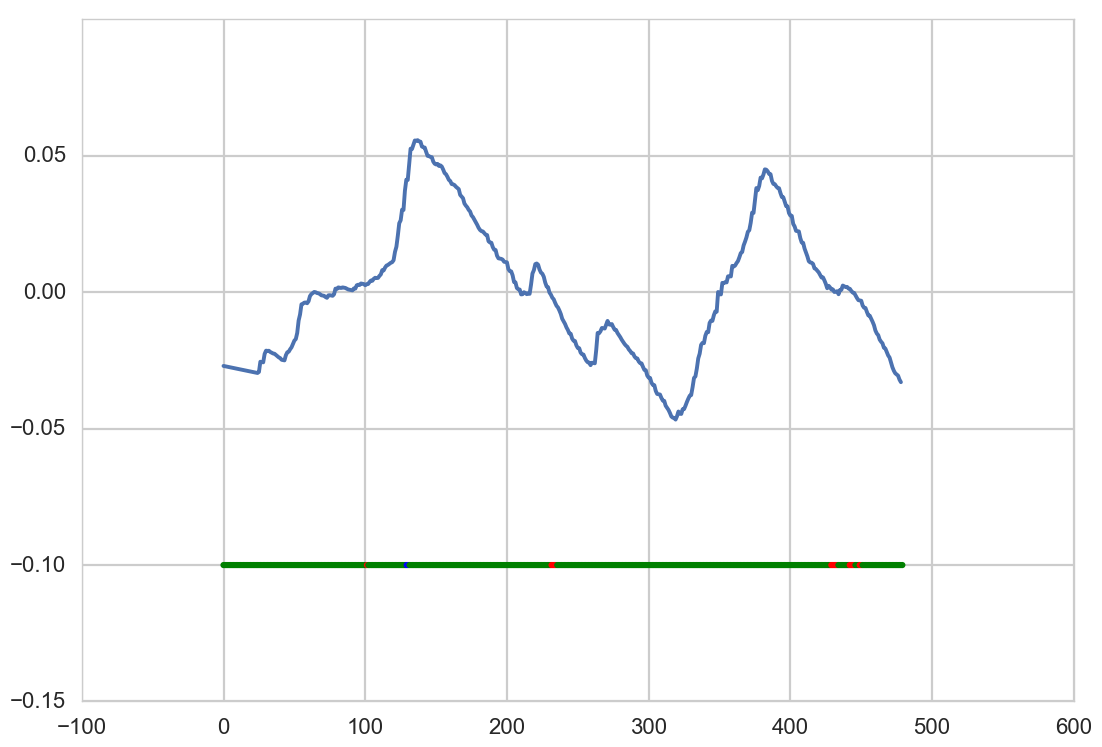

In [85]:
assign = np.round(np.mean(assignments[:,-int(assignments.shape[1] * 0.75):], axis=1)).astype(np.int)
# assign = res
plt.plot(Y)
plt.scatter(np.linspace(0,len(assign),num=len(assign)), -0.1*np.ones_like(assign), c=[c[i] for i in assign], lw=0)

In [84]:
[params['theta'][v] for v in np.unique(assign)]

[{'A': array([[5.9963145]], dtype=float32),
  'sigma': array([[0.02550523]], dtype=float32)},
 {'A': array([[0.13620634]], dtype=float32),
  'sigma': array([[20.754759]], dtype=float32)},
 {'A': array([[-7.3661156]], dtype=float32),
  'sigma': array([[0.00790192]], dtype=float32)}]

In [315]:
import ruptures as rpt

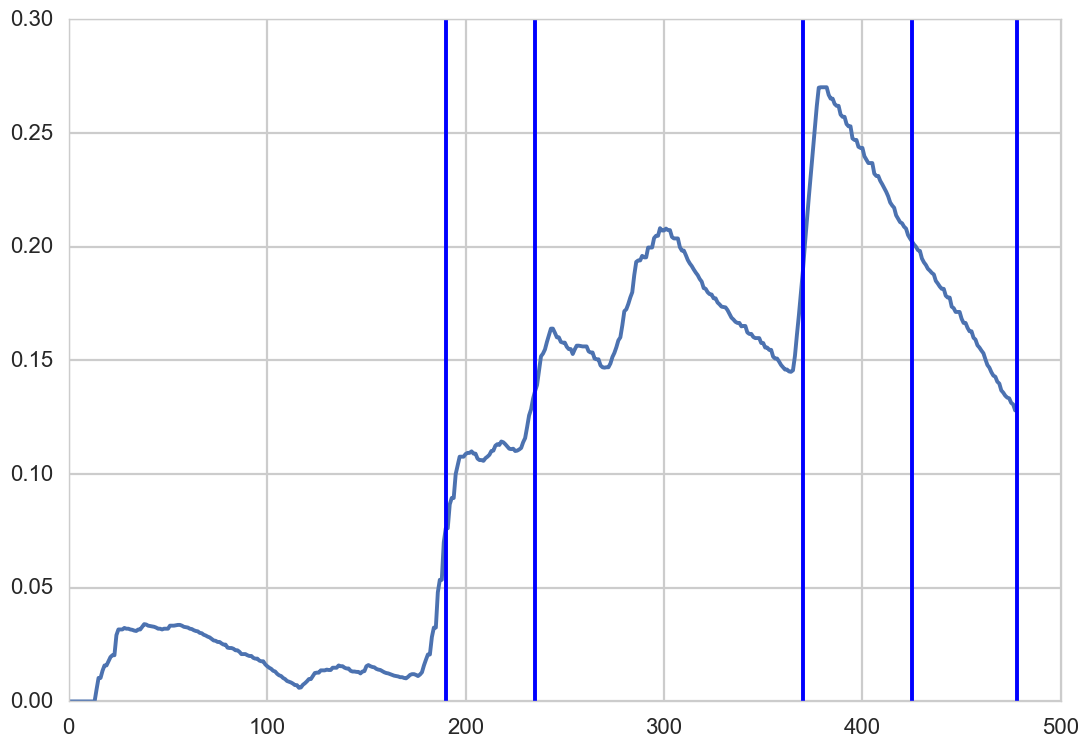

In [362]:
m = 5
# detection
algo = rpt.Pelt(model="rbf").fit(Y[:,m])
result = algo.predict(pen=10)

# display
# rpt.display(signal, bkps, result)
plt.plot(Y[:,m])
for v in result:
    plt.axvline(v)
# plt.show()

In [370]:
Y

array([ 0.00000e+00,  0.00000e+00, -9.71003e-03,  7.88223e-02,
        1.30935e-02,  1.26852e-02,  1.15560e-02,  1.00550e-02,
        9.03800e-03,  0.00000e+00,  1.10660e-02,  3.96000e-03,
        0.00000e+00, -2.64100e-03, -5.95300e-03,  0.00000e+00,
        1.40500e-03,  2.72100e-03,  0.00000e+00,  1.25530e-02,
       -1.58200e-03, -6.65900e-03,  0.00000e+00, -2.29480e-02,
       -1.00210e-02,  0.00000e+00,  0.00000e+00, -9.76700e-03,
       -4.64700e-03,  0.00000e+00, -8.33130e-03, -2.18770e-03,
        1.34840e-03, -1.29980e-03,  1.06480e-03, -5.69700e-03,
       -3.60500e-04,  2.75810e-03,  5.52370e-03,  8.97400e-04,
        3.53800e-03,  2.36490e-03,  2.98100e-03,  8.42600e-03,
        6.43000e-03,  6.81000e-03,  2.65600e-03,  2.45300e-03,
        2.20300e-03, -2.33800e-03, -1.72500e-03, -3.85800e-03,
       -6.58700e-03, -7.10100e-03, -5.57400e-03, -1.07321e-02,
       -7.01720e-03, -5.45230e-03, -5.99340e-03, -4.03030e-03,
       -3.59810e-03, -1.46650e-03,  4.23900e-04, -1.793

In [380]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

Y = df.Desert_Water.values*20

params = {}
L = 10
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[np.random.normal(1,1)]]), 'sigma': np.array([[10]])} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 50
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = .1*len(Y)
params['gamma'] = 50
params['priors'] = {
    'M': 0*np.eye(D),
    'K': 1*np.eye(D)
}

params, res, assignments, _ = hdp.sticky_HDP_AR(Y, params, priors=[np.cov(Y.T)*0.75, D+2],
                                             num_iter=1000,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=np.ones_like(Y))

Iteration: 0, # inf chain: 10, time: 1.46, hamming_dist: 405.000
Iteration: 10, # inf chain: 4, time: 1.12, hamming_dist: 92.000
Iteration: 20, # inf chain: 2, time: 1.13, hamming_dist: 1.000
Iteration: 30, # inf chain: 5, time: 1.15, hamming_dist: 54.000
Iteration: 40, # inf chain: 2, time: 1.13, hamming_dist: 48.000


KeyboardInterrupt: 

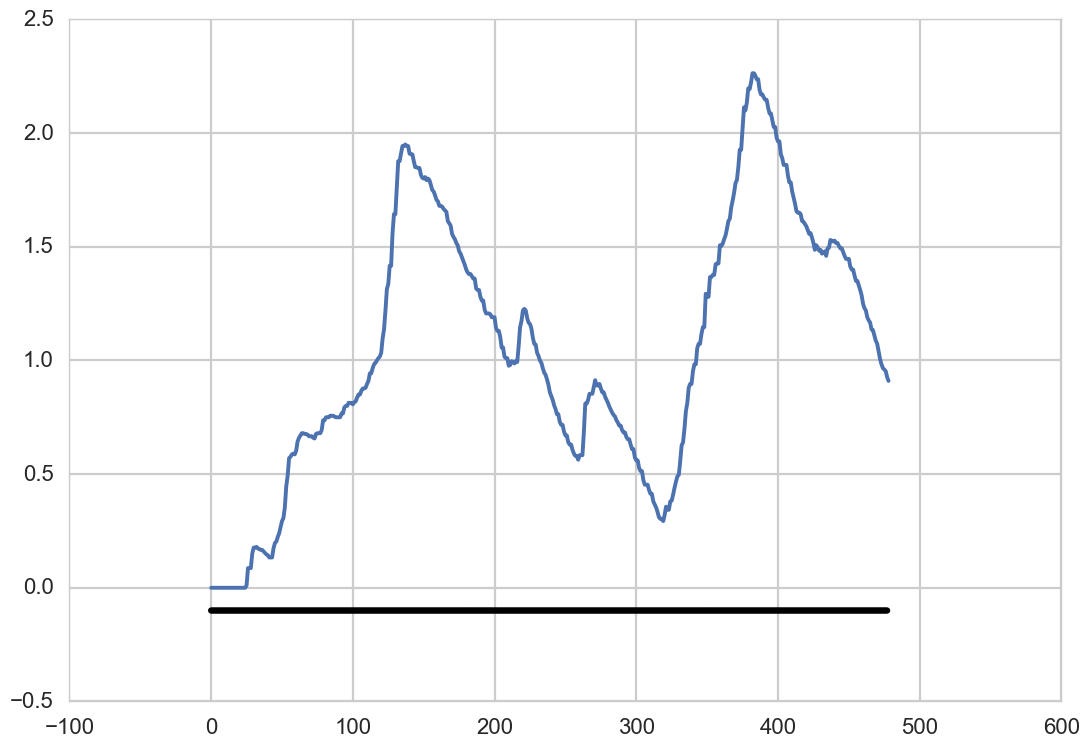

In [378]:
assign = assignments[:,-1]
# assign = res
plt.plot(df.Desert_Water.values*20)
plt.scatter(np.linspace(0,len(assign),num=len(assign)), -0.1*np.ones_like(assign), c=[c[i] for i in assign], lw=0)